In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython.display as ipd
import librosa.display
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,matthews_corrcoef,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


In [ ]:

# directories
real_male_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/male'
fake_male_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/male'

# Function to load audio files and convert them to a consistent sample rate
def load_audio_files(directory, sample_rate=22050):
    audio_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            path = os.path.join(directory, filename)
            audio, sr = librosa.load(path, sr=sample_rate)
            audio_files.append(audio)
    return audio_files

real_male_audios = load_audio_files(real_male_dir)
fake_male_audios = load_audio_files(fake_male_dir)

In [ ]:
real_female_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/female'
fake_female_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/female'
real_female_audios = load_audio_files(real_female_dir)
fake_female_audios = load_audio_files(fake_female_dir)

In [ ]:
# directories
real_my_voice_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/REAL/my_voice_real'
fake_my_voice_dir = '/content/drive/My Drive/TMU MSC/MRP/AUDIO/FAKE/my_fake_voice'

In [ ]:
my_real_audios = load_audio_files(real_my_voice_dir)
my_fake_audios = load_audio_files(fake_my_voice_dir)

In [ ]:
def slice_audio(audio, window_length=1, sr=22050):
    # Window length = 1 sec
    sample_length = window_length * sr
    return [audio[i:i+sample_length] for i in range(0, len(audio), sample_length) if len(audio[i:i+sample_length]) == sample_length]

# Slicing real and fake audio samples
real_male_slices = [slice for audio in real_male_audios for slice in slice_audio(audio, window_length=1)]
fake_male_slices = [slice for audio in fake_male_audios for slice in slice_audio(audio, window_length=1)]
real_female_slices = [slice for audio in real_female_audios for slice in slice_audio(audio, window_length=1)]
fake_female_slices = [slice for audio in fake_female_audios for slice in slice_audio(audio, window_length=1)]

In [ ]:
real_my_slices = [slice for audio in my_real_audios for slice in slice_audio(audio, window_length=1)]
fake_my_slices = [slice for audio in my_fake_audios for slice in slice_audio(audio, window_length=1)]

In [ ]:
def time_shift(audio, shift_max, sr):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(audio, shift)

# Apply time shift
real_augmented = [time_shift(audio, 1000, 22050) for audio in real_female_slices]

In [ ]:
real_augmented += [librosa.effects.pitch_shift(audio, sr=22050, n_steps=4) for audio in real_female_slices]

In [ ]:
real_augmented += [librosa.effects.time_stretch(audio,rate =  1.5) for audio in real_female_slices]

In [ ]:
real_female = real_augmented + real_female_slices +real_my_slices
fake_female =  fake_female_slices + fake_my_slices

In [ ]:
len(real_female),len(fake_female)


(2742, 6857)

<BarContainer object of 4 artists>

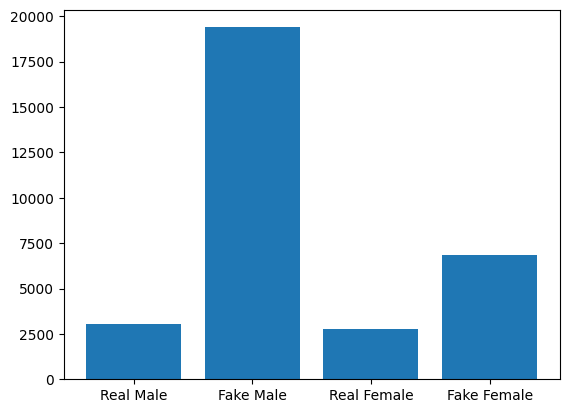

In [ ]:
plt.bar(['Real Male', 'Fake Male', 'Real Female', 'Fake Female'], [len(real_male_slices), len(fake_male_slices), len(real_female), len(fake_female)])

In [ ]:
#feature extraction and dataframe creation
sr = 22050
def extract_audio_features(files):
    features_list = []

    # Iterate over all files
    for y in files:
        # Extract features
        # Chromagram
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr).mean()

        # Root Mean Square Energy
        rms = librosa.feature.rms(y=y).mean()

        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

        # Spectral Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()

        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()

        # Mel-Frequency Cepstral Coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).mean(axis=1)

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()

        # Concatenate features as values for dataframe
        features = np.hstack((
            chroma_stft, rms, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate,
            mfccs, spectral_contrast
        ))

        features_list.append(features)

    # Create  DataFrame
    feature_names = [
        'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate'
    ] + [f'mfcc{i+1}' for i in range(mfccs.shape[0])] + ['spectral_contrast']

    df = pd.DataFrame(features_list, columns=feature_names)

    return df

features__male_real = extract_audio_features(real_male_slices)
features__male_fake = extract_audio_features(fake_male_slices)
features__female_real = extract_audio_features(real_female)
features__female_fake = extract_audio_features(fake_female)


In [ ]:
print(features__male_real.shape)
print(features__male_fake.shape)
print(features__female_real.shape)
print(features__female_fake.shape)

(3063, 27)
(19389, 27)
(2742, 27)
(6857, 27)


In [ ]:
features__female_real["gender"] = 1
features__female_fake["gender"] =1
features__male_real["gender"] = 0
features__male_fake["gender"] =0
features__female_real["label"] = 0
features__female_fake["label"] =1
features__male_real["label"] = 0
features__male_fake["label"] =1
final_df = pd.concat([features__female_real,features__female_fake,features__male_real,features__male_fake],axis=0)
print(final_df.shape)

(32051, 29)


In [ ]:
final_df.label.value_counts()

,count
label,
1,26246
0,5805


In [ ]:
final_df.gender.value_counts()

,count
gender,
0,22452
1,9599


In [ ]:
train_df, test_df = train_test_split(final_df, test_size=0.20, random_state=42)


In [ ]:
test_df.gender.value_counts()

,count
gender,
0,4486
1,1925


In [ ]:
#splitting in to independent and dependent variables
X = train_df.drop('label', axis=1)
y = train_df['label']

In [ ]:
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']

In [ ]:
random_forest = RandomForestClassifier(max_depth=None, n_estimators=200, random_state=42)
xgboost = XGBClassifier(learning_rate=0.2, max_depth=10, n_estimators=200, random_state=42)
lda = LinearDiscriminantAnalysis(solver='svd')
qda = QuadraticDiscriminantAnalysis(reg_param=0.0)


In [ ]:
random_forest.fit(X, y)
xgboost.fit(X, y)
lda.fit(X, y)
qda.fit(X, y)

QuadraticDiscriminantAnalysis()

In [ ]:
# Make predictions on test set
y_test_pred_rf = random_forest.predict(X_test)
y_test_pred_xgb = xgboost.predict(X_test)
y_test_pred_lda = lda.predict(X_test)
y_test_pred_qda = qda.predict(X_test)

# Classification report for Random Forest
print("Random Forest:")
print(classification_report(y_test, y_test_pred_rf))

# Classification report for XGBoost
print("XGBoost:")
print(classification_report(y_test, y_test_pred_xgb))

# Classification report for LDA
print("LDA:")
print(classification_report(y_test, y_test_pred_lda))

# Classification report for QDA
print("QDA:")
print(classification_report(y_test, y_test_pred_qda))

Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1133
           1       0.96      1.00      0.98      5278

    accuracy                           0.96      6411
   macro avg       0.97      0.90      0.93      6411
weighted avg       0.96      0.96      0.96      6411

XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1133
           1       0.98      0.99      0.99      5278

    accuracy                           0.98      6411
   macro avg       0.97      0.95      0.96      6411
weighted avg       0.98      0.98      0.98      6411

LDA:
              precision    recall  f1-score   support

           0       0.81      0.56      0.66      1133
           1       0.91      0.97      0.94      5278

    accuracy                           0.90      6411
   macro avg       0.86      0.76      0.80      6411
weighted avg       0.89      0.90      0.89  

In [ ]:
# Analyze misclassifications for each gender
test_df['predicted_rf'] = y_test_pred_rf
test_df['predicted_xgb'] = y_test_pred_xgb
test_df['predicted_lda'] = y_test_pred_lda
test_df['predicted_qda'] = y_test_pred_qda

In [ ]:
# Misclassified incidents
misclassified_rf_test = test_df[test_df['label'] != test_df['predicted_rf']]
misclassified_xgb_test = test_df[test_df['label'] != test_df['predicted_xgb']]
misclassified_lda_test = test_df[test_df['label'] != test_df['predicted_lda']]
misclassified_qda_test = test_df[test_df['label'] != test_df['predicted_qda']]

# Count misclassifications by gender
misclassified_by_gender_rf_test = misclassified_rf_test['gender'].value_counts()
misclassified_by_gender_xgb_test = misclassified_xgb_test['gender'].value_counts()
misclassified_by_gender_lda_test = misclassified_lda_test['gender'].value_counts()
misclassified_by_gender_qda_test= misclassified_qda_test['gender'].value_counts()

print("Misclassifications by Gender for Random Forest:")
print(misclassified_by_gender_rf_test)

print("Misclassifications by Gender for XGBoost:")
print(misclassified_by_gender_xgb_test)

print("Misclassifications by Gender for LDA:")
print(misclassified_by_gender_lda_test)

print("Misclassifications by Gender for QDA:")
print(misclassified_by_gender_qda_test)

Misclassifications by Gender for Random Forest:
gender
0    205
1     50
Name: count, dtype: int64
Misclassifications by Gender for XGBoost:
gender
0    108
1     40
Name: count, dtype: int64
Misclassifications by Gender for LDA:
gender
0    467
1    179
Name: count, dtype: int64
Misclassifications by Gender for QDA:
gender
0    298
1    120
Name: count, dtype: int64


In [ ]:
misclassified_by_gender_rf_test[1]

50

In [ ]:
rf_percentage_male =( misclassified_by_gender_rf_test[0]/ 4486)*100
rf_percentage_female = (misclassified_by_gender_rf_test[1]/ 1925)*100
xgboost_percentage_male = (misclassified_by_gender_xgb_test[0]/ 4486)*100
xgboost_percentage_female = (misclassified_by_gender_xgb_test[1]/ 1925)*100
lda_percentage_male = (misclassified_by_gender_lda_test[0]/ 4486)*100
lda_percentage_female = (misclassified_by_gender_lda_test[1]/ 1925)*100
qda_percentage_male = (misclassified_by_gender_qda_test[0]/ 4486)*100
qda_percentage_female = (misclassified_by_gender_qda_test[1]/ 1925)*100
df_misclassified_gender= pd.DataFrame({
    'Gender': ['Male', 'Female'],
    'Random Forest': [rf_percentage_male, rf_percentage_female],
    'XGBoost': [xgboost_percentage_male, xgboost_percentage_female],
    'LDA': [lda_percentage_male, lda_percentage_female],
    'QDA': [qda_percentage_male, qda_percentage_female]
})
df_misclassified_gender

,Gender,Random Forest,XGBoost,LDA,QDA
0,Male,4.569773,2.407490,10.410165,6.642889
1,Female,2.597403,2.077922,9.298701,6.233766


<Axes: xlabel='Gender'>

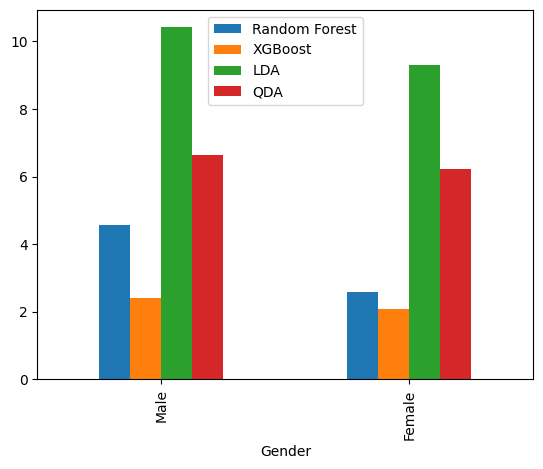

In [ ]:
df_misclassified_gender.plot(x='Gender', kind='bar')
#